# Convolutional Neural Network (CNN)

### Imports

In [2]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt

In [60]:
import numpy as np 
import pandas as pd 
#from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from glob import glob
import os
import matplotlib.pyplot as plt
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import seaborn as sns

### General settings


In [4]:
log_dir = "logs/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


### Load the dataset and format data

In [5]:
bishop = glob('data/Bishop/*.jpg')
king = glob('data/Bishop/*.jpg')
knight = glob('data/Bishop/*.jpg')
pawn = glob('data/Bishop/*.jpg')
queen = glob('data/Bishop/*.jpg')
rook = glob('data/rook/*.jpg')


In [6]:
# stats a bout the Data

print(f'in total there are {len(bishop) + len(king) + len(knight) + len(pawn) + len(queen) + len(rook)} images')
print(f'bishop: {len(bishop)}')
print(f'king: {len(king)}')
print(f'knight: {len(knight)}')
print(f'pawn: {len(pawn)}')
print(f'queen: {len(queen)}')
print(f'rook: {len(rook)}')


in total there are 442 images
bishop: 71
king: 71
knight: 71
pawn: 71
queen: 71
rook: 87


{'king': 76, 'queen': 78, 'bishop': 87, 'rook': 102, 'knight': 106, 'pawn': 107}


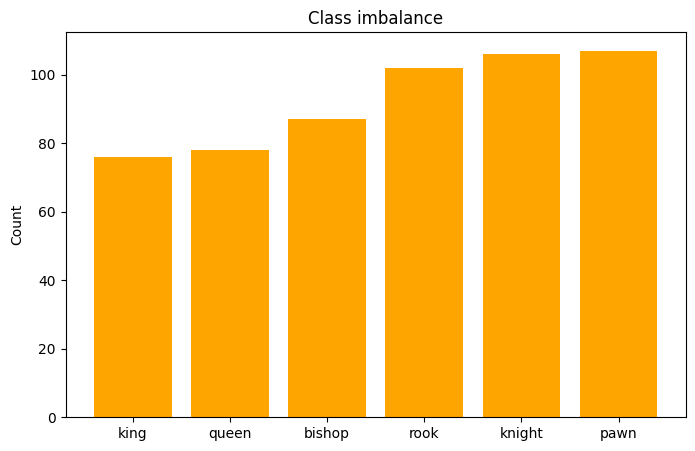

In [7]:
labels = ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
label_counts = dict()
for class_label in labels:
  label_counts[class_label] = len(os.listdir(f'data/{class_label}/'))

label_counts = dict(sorted(label_counts.items(), key=lambda x: x[1]))

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(list(label_counts.keys()), list(label_counts.values()), color ='orange')
plt.xlabel('') 
plt.ylabel('Count') 
ax.set_xticks(list(label_counts.keys()))
plt.title('Class imbalance') 

print(label_counts)

plt.show()

In [8]:
models_accuracy = dict()

In [9]:
def extract_class_weights():
    class_names = ['bishop', 'king', 'knight', 'pawn', 'queen', 'rook']
    
    class_counts = dict()
    for name in class_names:
        class_counts[name] = len(os.listdir('data/' + name))
    
    total = sum(class_counts.values())
    num_classes = len(class_names)
    
    class_weights = dict()
    for i in range(num_classes):
        class_weights[i] = total / (num_classes * list(class_counts.values())[i])
        print('{} {}: {:.2}'.format(i+1, class_names[i], class_weights[i]))
        
    return class_weights

extract_class_weights()

1 bishop: 1.1
2 king: 1.2
3 knight: 0.87
4 pawn: 0.87
5 queen: 1.2
6 rook: 0.91


{0: 1.0651340996168583,
 1: 1.219298245614035,
 2: 0.8742138364779874,
 3: 0.8660436137071651,
 4: 1.188034188034188,
 5: 0.9084967320261438}

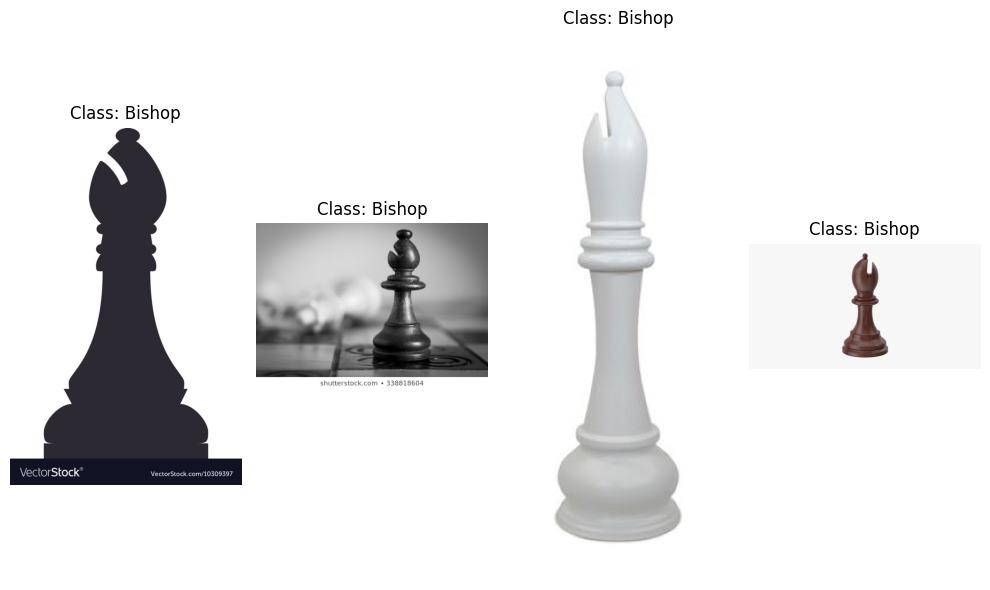

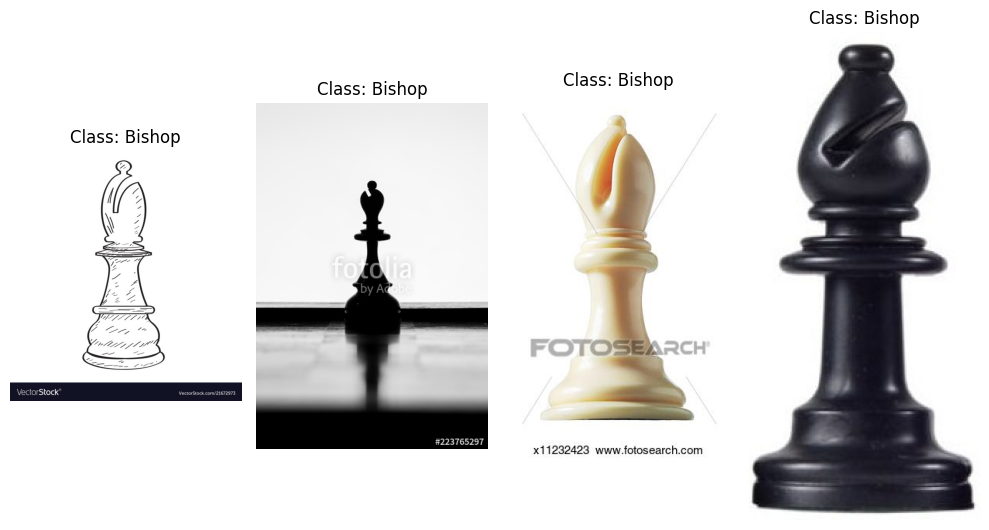

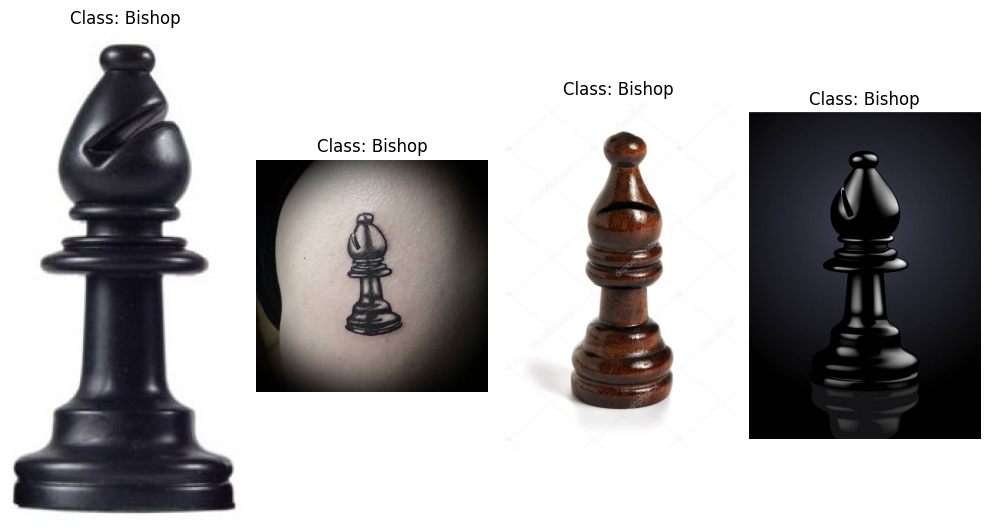

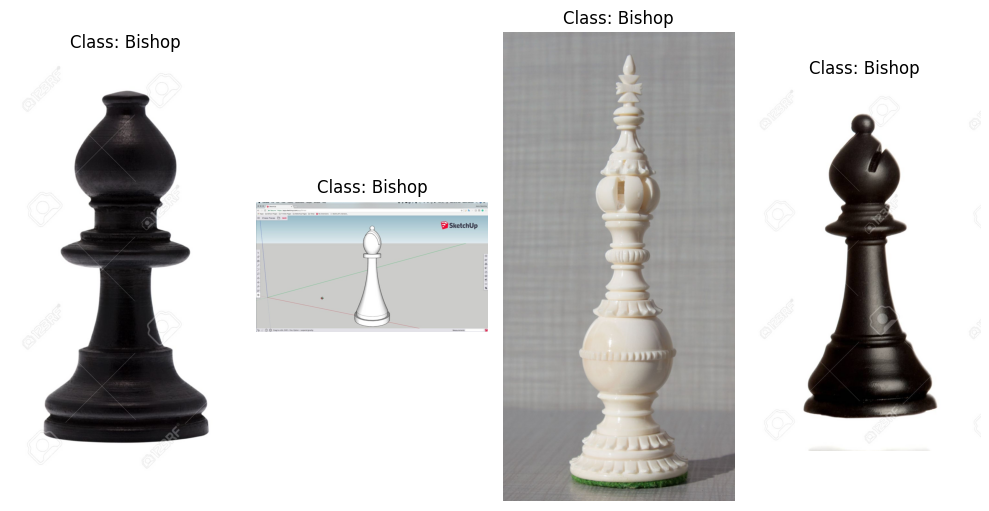

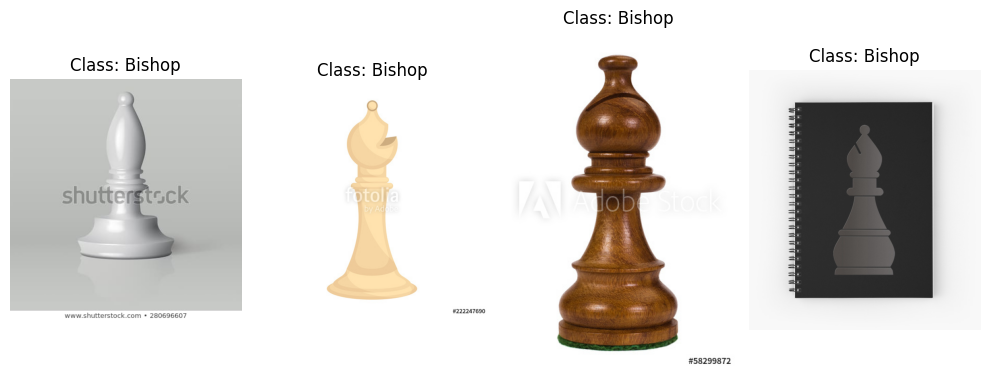

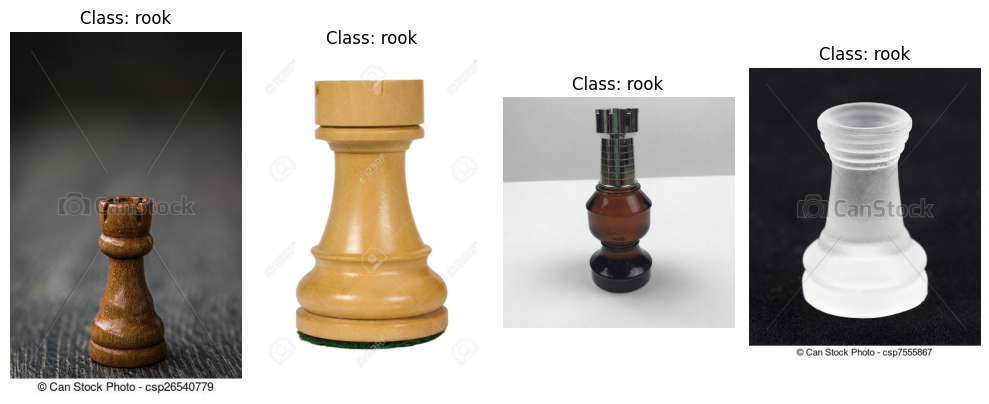

In [10]:

def display_images(label):
    import random
    from matplotlib.image import imread
    from pathlib import PurePath
    
    fig, axs = plt.subplots(1, 4, figsize=(10, 6), tight_layout=True)
    axs = axs.ravel()
    

    img_list = random.sample(label, 4)
    
    for i, img_path in enumerate(img_list):
        img = imread(img_path)
        label = PurePath(img_path).parent.name
        axs[i].set_title(f'Class: {label}', fontsize=12)
        axs[i].imshow(img, cmap='magma')
        axs[i].axis('off')
    plt.show()
    
display_images(bishop)
display_images(king)
display_images(knight)
display_images(pawn)
display_images(queen)
display_images(rook)

In [11]:
import numpy as np

resized_image_array = []
resized_image_array_label = []

SIZE = 32

def resize_images(image_directory):
    from PIL import Image
    
    target_size = (SIZE, SIZE)
    
    for file in image_directory:
        img = Image.open(file)

        img = img.convert('L')
        
        img = img.resize(target_size)
        array_temp = np.array(img)
        
        shape_new = SIZE * SIZE
        img_wide = array_temp.reshape(1, shape_new)
        resized_image_array.append(img_wide[0])
        
        if image_directory == bishop:
            resized_image_array_label.append(0)
        elif image_directory == king:
            resized_image_array_label.append(1)
        elif image_directory == knight:
            resized_image_array_label.append(2)
        elif image_directory == pawn:
            resized_image_array_label.append(3)
        elif image_directory == queen:
            resized_image_array_label.append(4)
        elif image_directory == rook:
            resized_image_array_label.append(5)
            
resize_images(bishop)
resize_images(king)
resize_images(knight)
resize_images(pawn)
resize_images(queen)
resize_images(rook)



In [74]:


train_images, temp_images, train_labels, temp_labels = train_test_split(
    resized_image_array, resized_image_array_label, test_size=0.3, shuffle=True, random_state=7)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, shuffle=True, random_state=7)

train_images = np.array(train_images).reshape(-1, SIZE, SIZE, 1)
val_images = np.array(val_images).reshape(-1, SIZE, SIZE, 1)
test_images = np.array(test_images).reshape(-1, SIZE, SIZE, 1)

train_labels = np.array(train_labels)
val_labels = np.array(val_labels)
test_labels = np.array(test_labels)

print(f"Training set size: {len(train_images)}")
print(f"Validation set size: {len(val_images)}")
print(f"Test set size: {len(test_images)}")


Training set size: 309
Validation set size: 66
Test set size: 67


## Initialize model and set parameters (CNN)

In [75]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(SIZE, SIZE, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(48, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))

In [76]:
model.summary()

Model: "sequential_317"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 30, 30, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 13, 13, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 48)       │        13,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_317 (Flatten)           │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1261 (Dense)              │ (None, 64)             │        49,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1262 (Dense)              │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,278 (266.71 KB)

 Trainable params: 68,278 (266.71 KB)

 Non-trainable params: 0 (0.00 B)

### Compile and train the model

In [77]:
import tensorflow as tf



model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)



history = model.fit(train_images, train_labels, epochs=40,
                    validation_data=(val_images, val_labels), callbacks=[tensorboard_callback, early_stopping])


test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'\nTest accuracy: {test_acc}')

Epoch 1/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5362 - loss: 8.0035 - val_accuracy: 0.7576 - val_loss: 4.7180
Epoch 2/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6574 - loss: 2.5238 - val_accuracy: 0.7727 - val_loss: 1.4171
Epoch 3/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6959 - loss: 1.2216 - val_accuracy: 0.6818 - val_loss: 0.5956
Epoch 4/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6923 - loss: 0.8020 - val_accuracy: 0.7424 - val_loss: 0.6415
Epoch 5/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7880 - loss: 0.4901 - val_accuracy: 0.7879 - val_loss: 0.7851
Epoch 6/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8212 - loss: 0.5427 - val_accuracy: 0.7879 - val_loss: 0.9162
Epoch 7/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8555 - loss: 0.4895 - val_accuracy: 0.7576 - val_loss: 0.6507
Epoch 8/40
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9095 - loss: 0.2305 - val_accuracy: 0.8182 - v

### Evaluate the model

3/3 - 0s - 9ms/step - accuracy: 0.9104 - loss: 0.2788


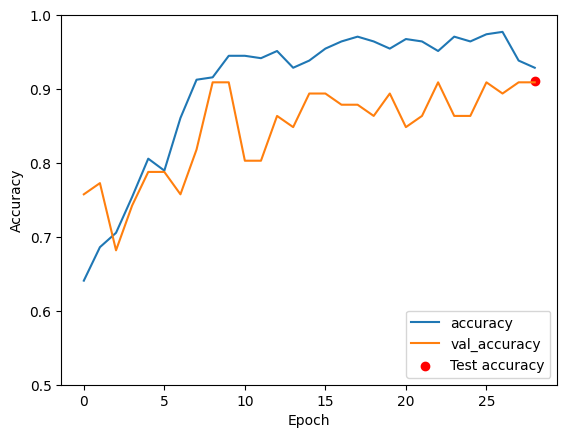

In [81]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])

# add red point to show test accuracy
plt.scatter(len(history.history['accuracy'])-1, test_acc, color='red', label='Test accuracy')

plt.legend(loc='lower right')


test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

## Initialize model and set parameters (MLP)

In [57]:
def build_mlp_model(hidden_layers, units, input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    
    for _ in range(hidden_layers):
        model.add(layers.Dense(units, activation='relu'))
        
    model.add(layers.Dense(6, activation='softmax'))  # Output layer for classification
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    return model


In [66]:
MLP_models = []
MLP_info = []

hidden_units = [32, 64, 128, 256, 512]
layer_counts = range(1, 6)

average_accuracies = np.zeros((len(layer_counts), len(hidden_units)))

for h_idx, h in enumerate(hidden_units):
    for l_idx, num_layers in enumerate(layer_counts):
        accuracies = []
        print(f"Training models with {num_layers} hidden layers and {h} units per layer...")
        
        for trial in range(5):  # Train each configuration 5 times
            # Build and compile the model
            model = build_mlp_model(num_layers, h, input_shape=(SIZE, SIZE, 1))
            
            # Early stopping to avoid overfitting
            early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
            
            # Train the model
            model.fit(train_images, train_labels, 
                      epochs=40, 
                      validation_data=(val_images, val_labels), 
                      callbacks=[tensorboard_callback, early_stopping], 
                      verbose=0)  # Verbose 0 to suppress output
            
            # Evaluate the model on the test set
            test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
            
            # Store accuracy for this trial
            accuracies.append(test_acc)
        
        # Compute average accuracy across 5 runs
        avg_accuracy = np.mean(accuracies)
        average_accuracies[l_idx, h_idx] = avg_accuracy  # Store in the matrix

        print(f"Average accuracy for {num_layers} layers, {h} units: {avg_accuracy:.4f}")


Training models with 1 hidden layers and 32 units per layer...


/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Average accuracy for 1 layers, 32 units: 0.6716
Training models with 2 hidden layers and 32 units per layer...
Average accuracy for 2 layers, 32 units: 0.7224
Training models with 3 hidden layers and 32 units per layer...
Average accuracy for 3 layers, 32 units: 0.7493
Training models with 4 hidden layers and 32 units per layer...
Average accuracy for 4 layers, 32 units: 0.8209
Training models with 5 hidden layers and 32 units per layer...
Average accuracy for 5 layers, 32 units: 0.8388
Training models with 1 hidden layers and 64 units per layer...
Average accuracy for 1 layers, 64 units: 0.7761
Training models with 2 hidden layers and 64 units per layer...
Average accuracy for 2 layers, 64 units: 0.7701
Training models with 3 hidden layers and 64 units per layer...
Average accuracy for 3 layers, 64 units: 0.7940
Training models with 4 hidden layers and 64 units per layer...
Average accuracy for 4 layers, 64 units: 0.8358
Training models with 5 hidden layers and 64 units per layer...
A

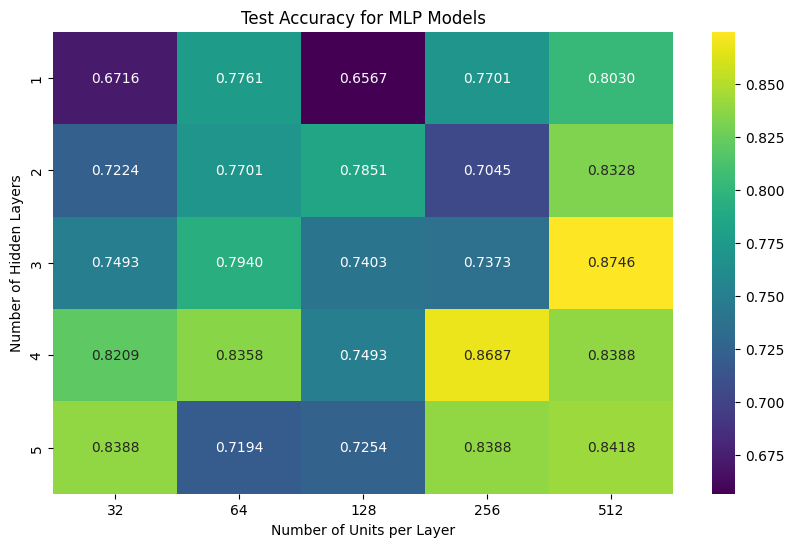

In [68]:
accuracy_matrix = np.array(MLP_info)

# Set up the heatmap using seaborn or matplotlib
plt.figure(figsize=(10, 6))

# Use seaborn heatmap for better aesthetics
sns.heatmap(average_accuracies, annot=True, cmap='viridis', fmt=".4f", 
            xticklabels=[32, 64, 128, 256, 512], 
            yticklabels=[1, 2, 3, 4, 5])

# Add labels and title
plt.xlabel('Number of Units per Layer')
plt.ylabel('Number of Hidden Layers')
plt.title('Test Accuracy for MLP Models')

# Display the heatmap
plt.show()

In [70]:
m = build_mlp_model(3,512, input_shape=(SIZE, SIZE, 1))
print(m.summary())
m2 = build_mlp_model(4,256, input_shape=(SIZE, SIZE, 1))
print(m2.summary())

/opt/miniconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_314"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_314 (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1250 (Dense)              │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1251 (Dense)              │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1252 (Dense)              │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1253 (Dense)              │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,053,190 (4.02 MB)

 Trainable params: 1,053,190 (4.02 MB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_315"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_315 (Flatten)           │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1254 (Dense)              │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1255 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1256 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1257 (Dense)              │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1258 (Dense)              │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 461,318 (1.76 MB)

 Trainable params: 461,318 (1.76 MB)

 Non-trainable params: 0 (0.00 B)

None
